# Code

In [1]:
import pandas as pd
import os
import time
import numpy as np
import sys
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
import multiprocessing
import pickle
import random
sys.path.insert(0, '..')
import dataset.preprocessing as utils
from config import *

random.seed(23)

In [2]:
how = 'paris'

assert how in ['paris', 'ricseq', 'mario']

MIN_N_READS_RICSEQ = 2

In [3]:
info = utils.read_dataframe(os.path.join(original_files_dir, 'index_bio_regions.Tx.RI_ALL.txt'), columns_to_drop = ['Unnamed: 0'])
info.loc[info["specie"] == "hs", "specie"] = "human"
info.loc[info["specie"] == "mm", "specie"] = "mouse"
#they are already mapped so the strand should be always '+'
assert (info.strand_1 == info.strand_2).all()
assert set(info.strand_2) == {'+'}
info = info.drop(['strand_1', 'strand_2'], axis = 1)

In [4]:
repeats_info = pd.read_csv(os.path.join(original_files_dir, f'index_repeats.Tx.RI_ALL.txt'), sep = '\t')[['name_1', 'Simple_repeat_unknown', 'SINE_Alu', 'Low_complexity_unknown']]

def check_for_R(value):
    return 'R' in value

repeats_info['Simple_repeat_unknown'] = repeats_info['Simple_repeat_unknown'].apply(check_for_R)
simple_repeats = set(repeats_info[repeats_info.Simple_repeat_unknown].name_1)
    
repeats_info['SINE_Alu'] = repeats_info['SINE_Alu'].apply(check_for_R)
sine_alu = set(repeats_info[repeats_info.SINE_Alu].name_1)

repeats_info['Low_complexity_unknown'] = repeats_info['Low_complexity_unknown'].apply(check_for_R)
low_complex = set(repeats_info[repeats_info.Low_complexity_unknown].name_1)

assert low_complex == set(info[info.name.isin(low_complex)].name)
assert sine_alu == set(info[info.name.isin(sine_alu)].name)
assert simple_repeats == set(info[info.name.isin(simple_repeats)].name)

info['simple_repeats'], info['sine_alu'], info['low_complex'] = False, False, False
 
info.loc[info["name"].isin(simple_repeats), "simple_repeats"] = True
info.loc[info["name"].isin(sine_alu), "sine_alu"] = True
info.loc[info["name"].isin(low_complex), "low_complex"] = True

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,4,6,8,22,26,36,37,42,44,45,46,56,57,58,59,60,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)

all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}
all_interactions = all_interactions.drop(['strand1', 'strand2'], axis = 1)

paris_experiments = ['hs_PARIS1__Hela_highRNase', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__Hela_lowRNase', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293_AMT', 'hs_PARIS2__HEK293_Amoto']
mario_experiments = ['mm_MARIO__mES']
ricseq_experiments = ['hs_RIC-seq__HeLa_merge.InterGene.arms']

assert set(paris_experiments).union(mario_experiments).union(ricseq_experiments) == set(all_interactions.experiment.value_counts().index)

#accorpiamo alcuni esperimenti per generare i negativi 
#[hs_PARIS2__HEK293_AMT, hs_PARIS2__HEK293_Amoto]
#[hs_PARIS1__Hela_highRNase, hs_PARIS1__Hela_lowRNase]
all_interactions.loc[all_interactions["experiment"] == "hs_PARIS2__HEK293_AMT", "experiment"] = "hs_PARIS2__HEK293"
all_interactions.loc[all_interactions["experiment"] == "hs_PARIS2__HEK293_Amoto", "experiment"] = "hs_PARIS2__HEK293"
all_interactions.loc[all_interactions["experiment"] == "hs_PARIS1__Hela_highRNase", "experiment"] = "hs_PARIS1__Hela"
all_interactions.loc[all_interactions["experiment"] == "hs_PARIS1__Hela_lowRNase", "experiment"] = "hs_PARIS1__Hela"

paris_experiments = ['hs_PARIS1__Hela', 'mm_PARIS2__GSM4503873_Mouse_brain_mRNA', 'hs_PARIS1__HEK293T', 'hs_PARIS2__GSM4503872_HEK293_mRNA', 'mm_PARIS1__mES', 'hs_PARIS2__HEK293']

assert set(paris_experiments).union(mario_experiments).union(ricseq_experiments) == set(all_interactions.experiment.value_counts().index)

### Create df genes

In [6]:
if os.path.isfile(os.path.join(processed_files_dir, f'df_genes.csv')):
    df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
else:
    human_annotations = utils.read_dataframe(os.path.join(original_files_dir, 'annotation_by_biomaRt_hs.txt'), columns_to_drop = ['Unnamed: 0', 'transcript_biotype', 'external_gene_name', '5utr', '3utr', 'cds', 'ID'])
    mouse_annotations = utils.read_dataframe(os.path.join(original_files_dir, 'annotation_by_biomaRt_mm.txt'), columns_to_drop = ['Unnamed: 0', 'transcript_biotype', 'external_gene_name', '5utr', '3utr', 'cds', 'ID'])
    human_annotations['specie'] = 'human'
    mouse_annotations['specie'] = 'mouse'
    annotations = pd.concat([human_annotations, mouse_annotations], axis = 0)
    del mouse_annotations, human_annotations

    all_transcript_ids = set(all_interactions.tr1).union(all_interactions.tr2)
    annotations = annotations[annotations.ensembl_transcript_id.isin(all_transcript_ids)]
    assert set(annotations.ensembl_transcript_id) == all_transcript_ids

    #adjust features
    annotations['protein_coding'] = False
    annotations.loc[ annotations['gene_biotype'] == 'protein_coding', 'protein_coding'] = True

    annotations = annotations.rename({'ensembl_gene_id':'gene_id'}, axis = 1)

    annotations.loc[ annotations['UTR5'] == '/', 'UTR5'] = np.nan
    annotations.loc[ annotations['CDS'] == '/', 'CDS'] = np.nan
    annotations.loc[ annotations['UTR3'] == '/', 'UTR3'] = np.nan

    assert annotations[annotations['UTR3'].isna()]['UTR5'].isna().all()
    assert annotations[annotations['UTR3'].isna()]['CDS'].isna().all()
    assert annotations[annotations['UTR5'].isna()]['CDS'].isna().all()

    annotations[['UTR3', 'UTR5', 'CDS']] = annotations[['UTR3', 'UTR5', 'CDS']].apply(pd.to_numeric)

    df_genes = annotations.reset_index(drop = True).copy()
    del annotations

    # CREATE df_genes for paris, ricseq, mario
    df_genes.to_csv(os.path.join(processed_files_dir, f'df_genes.csv'), index = False)

In [7]:
if how == 'paris':
    subset_interactions = all_interactions[all_interactions['experiment'].isin(paris_experiments)].reset_index(drop = True)
elif how == 'ricseq':
    subset_interactions = all_interactions[all_interactions['experiment'].isin(ricseq_experiments)].reset_index(drop = True)
    subset_interactions['n_reads'] = subset_interactions['n_reads'].apply(pd.to_numeric)
    subset_interactions = subset_interactions[subset_interactions.n_reads>=MIN_N_READS_RICSEQ]
elif how == 'mario':
    subset_interactions = all_interactions[all_interactions['experiment'].isin(mario_experiments)].reset_index(drop = True)
else:
    raise NotImplementedError
    
assert set(subset_interactions.merge(info, on = 'name')['name']) == set(subset_interactions['name'])
merged = subset_interactions.merge(info, on = 'name')
merged = merged.rename({'ensembl_gene_id_1':'gene_id1', 'ensembl_gene_id_2':'gene_id2'}, axis = 1)

assert (merged.tr1 == merged.chrom_1).all()
assert (merged.tr2 == merged.chrom_2).all()
assert (merged.x1 == merged.start_1).all()
assert (merged.x2 == merged.end_1).all()
assert (merged.y1 == merged.start_2).all()
assert (merged.y2 == merged.end_2).all()

merged = merged.drop(['chrom_1', 'chrom_2', 'start_1', 'end_1', 'start_2', 'end_2', 
                      'score', 'external_gene_name_1', 'external_gene_name_2', 
                      'chrom_1_localization', 'chrom_2_localization', 
                      'gene_biotype_1', 'gene_biotype_2'], axis = 1)

merged = merged.merge(df_genes[['ensembl_transcript_id', 'protein_coding', 'length']], left_on = 'tr1', right_on = 'ensembl_transcript_id').rename(
{'ensembl_gene_id':'gene1', 'length': 'length1', 'protein_coding':'protein_coding1'}
, axis = 1)
merged = merged.drop(['ensembl_transcript_id'], axis = 1)

merged = merged.merge(df_genes[['ensembl_transcript_id', 'protein_coding', 'length']], left_on = 'tr2', right_on = 'ensembl_transcript_id').rename(
{'ensembl_gene_id':'gene2', 'length': 'length2', 'protein_coding':'protein_coding2'}
, axis = 1)

merged = merged.drop(['ensembl_transcript_id'], axis = 1)

assert len(df_genes.gene_id.unique()) == len(df_genes.ensembl_transcript_id.unique()) == df_genes.shape[0]
assert set(merged.tr1).union(merged.tr2).intersection(set(df_genes.ensembl_transcript_id)) == set(merged.tr1).union(merged.tr2)
assert set(merged.gene_id1).union(merged.gene_id2).intersection(set(df_genes.gene_id)) == set(merged.gene_id1).union(merged.gene_id2)

In [8]:
merged[['couples', 'need_to_swap']] = merged[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)

def swap_genes_if_needed(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['tr1', 'tr2']] = (df.loc[where, ['tr2', 'tr1']].values)
    df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
    df.loc[where, ['length1', 'length2']] = (df.loc[where, ['length2', 'length1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df.loc[where, ['protein_coding1', 'protein_coding2']] = (df.loc[where, ['protein_coding2', 'protein_coding1']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    n_duplicates = original_dim - df.shape[0] 
    print(f"{n_duplicates} interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)")
    return df

merged = swap_genes_if_needed(merged)

merged['w'] = merged['x2'] - merged['x1']
merged['h'] = merged['y2'] - merged['y1']
merged = merged.drop(['tr1', 'tr2', 'y2', 'x2'], axis = 1).rename(
    {'gene_id1':'gene1', 'gene_id2':'gene2', 
     'protein_coding1':'protein_coding_1', 'protein_coding2':'protein_coding_2',
     'length1':'length_1', 'length2':'length_2'
    }, axis = 1)

merged['interacting'] = True

#order columns
merged = merged[['couples', 'name', 'other_id', 'experiment', 
                 'gene1', 'gene2', 'interacting',
                 'x1', 'y1', 'w', 'h', 
                 'specie', 'length_1', 'length_2',
                 'protein_coding_1', 'protein_coding_2', 
                'simple_repeats', 'sine_alu', 'low_complex', 'n_reads']]

assert set(merged[merged.specie == 'mouse'].gene1).union(merged[merged.specie == 'mouse'].gene2) - set(df_genes[df_genes.specie == 'mouse'].gene_id) == set()
assert set(merged[merged.specie == 'human'].gene1).union(merged[merged.specie == 'human'].gene2) - set(df_genes[df_genes.specie == 'human'].gene_id) == set()

0 interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)


# Accorpo le interazioni nella stessa regione

Se ci sono piu regioni overlappanti per una coppia, e le devo accorpare, per le colonne ['name','other_id','experiment'] ne scelgo una a caso. Creo una nuova colonna inoltre, chiamata 'is_merged', che diventa True se sono regioni accorpate, False altrimenti.

In [4]:
def clean_bbox(int_or):

    #36 min ricseq
    diz_int = {}
    idx = 0
    for couple in tqdm(int_or.couples.unique()):
        subset = int_or[int_or.couples == couple]
        list_of_boxes = subset.filter(['x1', 'y1', 'w', 'h']).values.tolist()
        new_list_of_boxes = utils.clean_bounding_boxes(list_of_boxes)
        
        for box in new_list_of_boxes:
            x1, y1, w, h  = box[0], box[1], box[2], box[3]
            
            correct_row = int_or[
                (int_or.x1 == x1)&(int_or.y1 == y1)&(int_or.w == w)&(int_or.h == h)
            ]
            if correct_row.shape[0] > 0:
                row = correct_row.iloc[0]
                d = dict(row)
                d['is_merged'] = False
            else:
                row = int_or[int_or.couples == couple].sample(1).iloc[0]
                d = dict(row)
                d['is_merged'] = True
                d['name'] = np.nan
                d['other_id'] = np.nan
            
            d['x1'], d['y1'], d['w'], d['h'],  = x1, y1, w, h
            diz_int[idx] = d
            idx+=1

    df_int = pd.DataFrame.from_dict(diz_int, 'index')
    return df_int


def parallel_clean_bbox(int_or, num_threads):
    unique_couples = int_or.couples.unique()
    chunk_size = len(unique_couples) // num_threads

    def process_chunk(chunk, shared_dict):
        for couple in chunk:
            diz_int = {}
            idx = 0
            subset = int_or[int_or.couples == couple]
            list_of_boxes = subset.filter(['x1', 'y1', 'w', 'h']).values.tolist()
            new_list_of_boxes = utils.clean_bounding_boxes(list_of_boxes)
            for box in new_list_of_boxes:
                x1, y1, w, h  = box[0], box[1], box[2], box[3]

                correct_row = int_or[
                    (int_or.x1 == x1)&(int_or.y1 == y1)&(int_or.w == w)&(int_or.h == h)
                ]
                if correct_row.shape[0] > 0:
                    row = correct_row.iloc[0]
                    d = dict(row)
                    d['is_merged'] = False
                else:
                    row = int_or[int_or.couples == couple].sample(1).iloc[0]
                    d = dict(row)
                    d['is_merged'] = True
                    d['name'] = np.nan
                    d['other_id'] = np.nan

                d['x1'], d['y1'], d['w'], d['h'],  = x1, y1, w, h
                diz_int[idx] = d
                idx+=1

            shared_dict[couple] = diz_int

    manager = multiprocessing.Manager()
    shared_dict = manager.dict()

    chunks = [unique_couples[i:i+chunk_size] for i in range(0, len(unique_couples), chunk_size)]

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        executor.map(lambda chunk: process_chunk(chunk, shared_dict), chunks)
        
    diz_int = {}
    idx = 0
    for chunk_diz_int in shared_dict.values():
        for k in chunk_diz_int.keys():
            diz_int[idx] = chunk_diz_int[k]
            idx += 1
    df_int = pd.DataFrame.from_dict(diz_int, 'index')
    return df_int

In [10]:
%%time 
# 1 ora paris, 1 minuto ricseq

if os.path.isfile(os.path.join(processed_files_dir, f'{how}_int.csv')):
    df_int = pd.read_csv(os.path.join(processed_files_dir, f'{how}_int.csv'))
else:

    to_clean, cleaned = merged[merged.couples.duplicated()], merged[~merged.couples.duplicated()]
    assert cleaned.shape[0] + to_clean.shape[0] == merged.shape[0]

    cleaned['is_merged'] = False
    new_cleaned = clean_bbox(to_clean) #new_cleaned = parallel_clean_bbox(to_clean, 10)

    df_int = pd.concat([cleaned, new_cleaned], axis = 0)

    assert set(df_int.couples) == set(merged.couples)

    df_int.to_csv(os.path.join(processed_files_dir, f'{how}_int.csv'), index = False)

CPU times: user 6.23 ms, sys: 284 µs, total: 6.52 ms
Wall time: 6.05 ms


# Create negatives

Criteri: 

- stesso esperimento
- stesso biotipo dell interazione (cds-noncoding, utr3-utr5, noncoding-noncoding, ecc...)

per le colonne 	['simple_repeats','sine_alu','low_complex', 'n_reads', 'is_merged'] dobbiamo mettere np.nan

In [7]:
def create_interactions_columns(df, df_genes):

    df = df.merge(df_genes, left_on = 'gene1', right_on = 'gene_id')
    df['where_x1'] = 'none'
    df.loc[(df.x1 < df.UTR5), 'where_x1'] = 'UTR5'
    df.loc[(df.x1 >= df.UTR5)&(df.x1 < df.CDS), 'where_x1'] = 'CDS'
    df.loc[(df.x1 >= df.CDS), 'where_x1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    
    df = df.merge(df_genes, left_on = 'gene2', right_on = 'gene_id')
    df['where_y1'] = 'none'
    df.loc[(df.y1 < df.UTR5), 'where_y1'] = 'UTR5'
    df.loc[(df.y1 >= df.UTR5)&(df.y1 < df.CDS), 'where_y1'] = 'CDS'
    df.loc[(df.y1 >= df.CDS), 'where_y1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    return df

def where_interacts(x):
    a,b = sorted([x.where_x1, x.where_y1])
    return a + '-' + b

In [8]:
#create train, test, val lists

def train_test_val_split(all_couples, train_frac = 0.7, return_val = True):
    random.seed(23)
    testval_frac = 1 - train_frac
    if return_val:
        val_frac = testval_frac/2

    #Shuffle the list randomly
    random.shuffle(all_couples)

    # Calculate the sizes of each part
    total_count = len(all_couples)
    train_size = int(train_frac * total_count)
    if return_val:
        test_size = int(val_frac * total_count)
        val_size = total_count - train_size - test_size
        
        # Divide the list into three parts
        train_list = all_couples[:train_size]
        test_list = all_couples[train_size:train_size + test_size]
        val_list = all_couples[train_size + test_size:]
        
         # Print the sizes of the three parts
        print("Train List Size:", len(train_list))
        print("Test List Size:", len(test_list))
        print("Validation List Size:", len(val_list))
        assert set(train_list).union(test_list).union(val_list) == set(all_couples)
        assert set(train_list).intersection(test_list).intersection(val_list) == set()
        
        return train_list, test_list, val_list
        
    else:
        train_list = all_couples[:train_size]
        test_list = all_couples[train_size:]
        
        print("Train List Size:", len(train_list))
        print("Test List Size:", len(test_list))
        assert set(train_list).union(test_list) == set(all_couples)
        assert set(train_list).intersection(test_list) == set()
        
        return train_list, test_list

In [9]:
def swap_genes_if_needed2(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['gene1', 'gene2']] = (df.loc[where, ['gene2', 'gene1']].values)
    df.loc[where, ['length_1', 'length_2']] = (df.loc[where, ['length_2', 'length_1']].values)
    df.loc[where, ['where_x1', 'where_y1']] = (df.loc[where, ['where_y1', 'where_x1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['w', 'h']] = (df.loc[where, ['h', 'w']].values)
    df.loc[where, ['protein_coding_1', 'protein_coding_2']] = (df.loc[where, ['protein_coding_2', 'protein_coding_1']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    return df

def obtain_negative_subset(df):
    
    assert len(set(df['specie'].value_counts().index)) == 1
    specie = df['specie'].iloc[0]

    assert len(set(df['experiment'].value_counts().index)) == 1
    experiment = df['experiment'].iloc[0]
    
    assert len(set(df['where'].value_counts().index)) == 1
    where = df['where'].iloc[0]
    
    keep_fix = df.filter(['gene1', 'x1', 'w', 'length_1', 'protein_coding_1', 'where_x1'], axis = 1).reset_index(drop = True)
    shuffle = df.filter(['gene2', 'y1', 'h', 'length_2', 'protein_coding_2', 'where_y1'], axis = 1).sample(frac=1, random_state = 23).reset_index(drop = True)
    df_concat = pd.concat([keep_fix, shuffle], axis = 1)

    df_concat[['couples', 'need_to_swap']] = df_concat.rename({'gene1':'gene_id1', 'gene2':'gene_id2'}, axis = 1)[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)
    
    df_concat = swap_genes_if_needed2(df_concat)

    df_concat['name'] = np.nan
    df_concat['experiment'] = experiment
    df_concat['specie'] = specie
    df_concat['interacting'] = False
    df_concat['other_id'] = np.nan
    df_concat['simple_repeats'] = np.nan
    df_concat['sine_alu'] = np.nan
    df_concat['low_complex'] = np.nan
    df_concat['n_reads'] = np.nan
    df_concat['is_merged'] = np.nan
    df_concat['where'] = where
    
    return df_concat.reset_index(drop = True)

def create_df_neg(df_int, how_many_negatives_per_positive, experiment_list):

    order_column = list(df_int.columns)

    negs = []

    for _ in tqdm(range(how_many_negatives_per_positive)):
        for exp in experiment_list:
            df_exp = df_int[df_int.experiment == exp].drop_duplicates().reset_index(drop = True)

            #order according to the interaction region
            df_exp['need_to_swap'] = df_exp['where_x1'] + '-' + df_exp['where_y1'] != df_exp['where']
            df_exp = swap_genes_if_needed2(df_exp)
            df_exp['couples'] = df_exp['gene1'] + '_' + df_exp['gene2']
            assert (df_exp['where_x1'] + '-' + df_exp['where_y1'] == df_exp['where']).all()

            for int_region in list(df_exp['where'].value_counts().index):
                subset = df_exp[df_exp['where'] == int_region].reset_index(drop = True)
                subset = obtain_negative_subset(subset)
                subset = subset.filter(order_column, axis = 1)
                negs.append(subset)

    df_neg = pd.concat(negs, axis = 0)
    return df_neg

In [23]:
#### Drop all the negative interactions that are seen positive in PARIS or in other experiments

def order_genes(x):
    x1, x2 = x.split('_')
    return utils.get_couple_id(x1, x2)

prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)

prohibited = set(prohibited_couples['id']).union(df_int['couples'])

In [24]:
how_many_negatives_per_positive = 2 

df_int = create_interactions_columns(df_int, df_genes[['gene_id', 'UTR5', 'CDS', 'UTR3']])
df_int['where'] = df_int.apply(where_interacts, axis = 1)
all_couples = list(df_int.couples.unique())

if how == 'paris':
    experiment_list = paris_experiments
    train_list, test_list, val_list = train_test_val_split(all_couples)
    dict_sets = {'train':train_list, 'test':test_list, 'val':val_list}
    
if how == 'ricseq':
    experiment_list = ricseq_experiments
    train_list, test_list = train_test_val_split(all_couples, return_val = False)
    dict_sets = {'train':train_list, 'test':test_list}

if how == 'mario':
    experiment_list = mario_experiments
    train_list, test_list = train_test_val_split(all_couples, return_val = False)
    dict_sets = {'train':train_list, 'test':test_list}
    
dfs = []
for k in dict_sets.keys():
    print(f'------ {k} ------')
    int_subset = df_int[df_int.couples.isin(dict_sets[k])].reset_index(drop = True)
    df_neg = create_df_neg(int_subset, how_many_negatives_per_positive, experiment_list)
    to_drop = set(df_neg['couples']).intersection(prohibited)
    
    df_neg = df_neg[~df_neg['couples'].isin(to_drop)].reset_index(drop = True)
    
    dict_sets[k] = list(set(df_neg['couples']).union(dict_sets[k]))
    
    df_set = pd.concat([int_subset, df_neg], axis = 0).reset_index(drop = True)
    dfs.append(df_set)
    
df = pd.concat(dfs, axis = 0).reset_index(drop = True)
del dfs

Train List Size: 68747
Test List Size: 14731
Validation List Size: 14732
------ train ------


  0%|          | 0/2 [00:00<?, ?it/s]

------ test ------


  0%|          | 0/2 [00:00<?, ?it/s]

------ val ------


  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
### PARIS train-test-val creation with only the true (big) interaction regions

treshold = 20 #bigger or equal than this number

df_int = df_int[(df_int.w >= treshold)&(df_int.h >= treshold)].reset_index(drop = True)

list_keys = list(dict_sets.keys())

if how == 'paris':

    dfs = []
    for k in list_keys:
        print(f'------ {k} HQ ------')
        int_subset = df_int[df_int.couples.isin(dict_sets[k])].reset_index(drop = True)
        
        assert int_subset.h.min() >= treshold
        assert int_subset.w.min() >= treshold
        
        df_neg = create_df_neg(int_subset, how_many_negatives_per_positive, experiment_list)
        to_drop = set(df_neg['couples']).intersection(prohibited)

        df_neg = df_neg[~df_neg['couples'].isin(to_drop)].reset_index(drop = True)
        
        assert df_neg.h.min() >= treshold
        assert df_neg.w.min() >= treshold

        dict_sets[f'{k}_HQ'] = list(set(df_neg['couples']).union(int_subset['couples']))

        df_set = pd.concat([int_subset, df_neg], axis = 0).reset_index(drop = True)
        dfs.append(df_set)

    df_hq = pd.concat(dfs, axis = 0).reset_index(drop = True)
    del dfs
    
    df = pd.concat([df, df_hq], axis = 0).drop_duplicates().reset_index(drop = True)
    del df_hq

------ train HQ ------


  0%|          | 0/2 [00:00<?, ?it/s]

------ test HQ ------


  0%|          | 0/2 [00:00<?, ?it/s]

------ val HQ ------


  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
### In the negative set, I want to keep only 1 negative for each positive, otherwise valentino classes has problems.
df_int, df_neg = df[df.interacting], df[df.interacting == False]

df_neg = df_neg.drop_duplicates('couples')

df = pd.concat([df_int, df_neg], axis = 0).drop_duplicates().reset_index(drop = True)

In [23]:
# è possibile ci siano <20 perche magari delle coppie hanno piu regioni di interazone, ma sono pochi casi

for k in list_keys:
    hq = df[df.couples.isin(dict_sets[f'{k}_HQ'])]
    assert hq[(hq.w < treshold) | (hq.h < treshold)].shape[0]/hq.shape[0] * 100 < 5

### Export

In [10]:
df.to_csv(os.path.join(processed_files_dir, f'{how}.csv'), index = False)

In [18]:
if how == 'paris':
    file_name_training, file_name_test, file_name_val = ['gene_pairs_training.txt', 'gene_pairs_test.txt', 'gene_pairs_val.txt']
    save_path = rna_rna_files_dir
    
    file_val = os.path.join(save_path, file_name_val)
    with open(file_val, "wb") as fp:   #Pickling
        pickle.dump(dict_sets['val'], fp)  
        
    file_name_training_HQ, file_name_test_HQ, file_name_val_HQ = ['gene_pairs_training_HQ.txt', 'gene_pairs_test_HQ.txt', 'gene_pairs_val_HQ.txt']

    file_name_training_HQ = os.path.join(save_path, file_name_training_HQ)
    file_name_test_HQ = os.path.join(save_path, file_name_test_HQ) 
    file_name_val_HQ = os.path.join(save_path, file_name_val_HQ)
    
    with open(file_name_training_HQ, "wb") as fp:   #Pickling
        pickle.dump(dict_sets['train_HQ'], fp)
    with open(file_name_test_HQ, "wb") as fp:   #Pickling
        pickle.dump(dict_sets['test_HQ'], fp)
    with open(file_name_val_HQ, "wb") as fp:   #Pickling
        pickle.dump(dict_sets['val_HQ'], fp) 

elif how in ['ricseq', 'mario']:
    file_name_training, file_name_test = ['gene_pairs_training.txt', 'gene_pairs_test.txt']
    save_path = os.path.join(rna_rna_files_dir, f'{how}')
    if os.path.isdir(save_path) == False:
        os.mkdir(save_path)
        
file_training = os.path.join(save_path, file_name_training)
file_test = os.path.join(save_path, file_name_test)    

with open(file_training, "wb") as fp:   #Pickling
    pickle.dump(dict_sets['train'], fp)

with open(file_test, "wb") as fp:   #Pickling
    pickle.dump(dict_sets['test'], fp)

# Ricseq HQ

In [21]:
filepath = os.path.join(os.path.join('ricseqHQ_couples.csv'))

if os.path.isfile(filepath):
    ricsechq = pd.read_csv(filepath)
else:
    ricsechq = pd.read_csv(os.path.join(original_files_dir, 'ricseqhq', 'HeLa_merge.significant.interMolecular.interaction.list'), sep = '\t')[['GeneA', 'GeneB']].drop_duplicates()
    human_annotations = pd.read_csv(os.path.join(original_files_dir, 'annotation_by_biomaRt_hs.txt'), sep = '\t')[['ensembl_gene_id', 'external_gene_name']].drop_duplicates()

    ricsechqensA = ricsechq[(ricsechq['GeneA'].str.startswith('ENS')) & (ricsechq['GeneB'].str.startswith('ENS') == False)]
    ricsechqensB = ricsechq[(ricsechq['GeneA'].str.startswith('ENS') == False) & (ricsechq['GeneB'].str.startswith('ENS'))]

    ok = ricsechq[(ricsechq['GeneA'].str.startswith('ENS')) & (ricsechq['GeneB'].str.startswith('ENS'))]
    ok = ricsechq[(ricsechq['GeneA'].str.startswith('ENS')) & (ricsechq['GeneB'].str.startswith('ENS'))]
    ok = ok.rename({'GeneB':'gene_id1', 'GeneA':'gene_id2'}, axis = 1)

    to_merge = ricsechq[~(ricsechq['GeneA'].str.startswith('ENS')) | (ricsechq['GeneB'].str.startswith('ENS'))]

    to_merge = to_merge.merge(human_annotations, how ='left', left_on = 'GeneA',right_on = 'external_gene_name')
    to_merge = to_merge.drop(['GeneA', 'external_gene_name'], axis = 1).rename({'ensembl_gene_id':'gene_id1'}, axis = 1)
    to_merge = to_merge.merge(human_annotations, how ='left', left_on = 'GeneB',right_on = 'external_gene_name')
    to_merge = to_merge.drop(['GeneB', 'external_gene_name'], axis = 1).rename({'ensembl_gene_id':'gene_id2'}, axis = 1)
    ok2 = to_merge.dropna()

    ricsechqensA = ricsechqensA.merge(human_annotations, how ='left', left_on = 'GeneB',right_on = 'external_gene_name')
    ricsechqensA = ricsechqensA.drop(['GeneB', 'external_gene_name'], axis = 1).rename({'ensembl_gene_id':'gene_id2', 'GeneA':'gene_id1'}, axis = 1)
    ok3 = ricsechqensA.dropna()

    ricsechqensB = ricsechqensB.merge(human_annotations, how ='left', left_on = 'GeneA',right_on = 'external_gene_name')
    ricsechqensB = ricsechqensB.drop(['GeneA', 'external_gene_name'], axis = 1).rename({'ensembl_gene_id':'gene_id1', 'GeneB':'gene_id2'}, axis = 1)
    ok4 = ricsechqensB.dropna()

    ricsechq = pd.concat([ok, ok2, ok3, ok4], axis = 0).dropna()

    ricsechq[['couples', 'need_to_swap']] = ricsechq[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)
    ricsechq = ricsechq[['couples']].reset_index(drop = True)
    
    ricsechq.to_csv(filepath, index = False)



def order_genes(x):
    x1, x2 = x.split('_')
    return utils.get_couple_id(x1, x2)
prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)

In [22]:
len(set(ricsechq['couples']) - set(prohibited_couples['id']))

1210750

In [23]:
len(set(ricsechq['couples']).intersection(set(prohibited_couples['id'])))

17116

In [24]:
len(set(prohibited_couples['id']))

599774

# Plot 

In [4]:
from util.plot_utils import plot_interaction_region, plot_matrix_area_kde_curves, plot_bar_n_reads_hist, plot_interacting_region_kde_paris, plot_interacting_region_hist_paris

<class 'transformers.tokenization_dna.DNATokenizer'>


In [5]:
def load_train_test_val_lists(rna_rna_files_dir, how = 'paris', hq = False):
    assert how in ['paris', 'mario', 'ricseq', 'splash']
    if how == 'paris':
        save_path = rna_rna_files_dir
        
        if hq:
            suffix = '_HQ'
        else:
            suffix = ''
            
        with open(os.path.join(save_path, f'gene_pairs_training{suffix}.txt'), "rb") as fp:   # Unpickling
                gene_pairs_train = pickle.load(fp)

        with open(os.path.join(save_path, f'gene_pairs_test{suffix}.txt'), "rb") as fp:   # Unpickling
                gene_pairs_test = pickle.load(fp)
        
        with open(os.path.join(save_path, f'gene_pairs_val{suffix}.txt'), "rb") as fp:   # Unpickling
            gene_pairs_val = pickle.load(fp)
            
        return gene_pairs_train, gene_pairs_test, gene_pairs_val
        
    else:
        save_path = os.path.join(rna_rna_files_dir, f'{how}')
        
        with open(os.path.join(save_path, 'gene_pairs_training.txt'), "rb") as fp:   # Unpickling
                gene_pairs_train = pickle.load(fp)

        with open(os.path.join(save_path, 'gene_pairs_test.txt'), "rb") as fp:   # Unpickling
                gene_pairs_test = pickle.load(fp)
        
        return gene_pairs_train, gene_pairs_test

In [6]:
how = 'paris'

In [7]:
df = pd.read_csv(os.path.join(processed_files_dir, f'{how}.csv'))
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


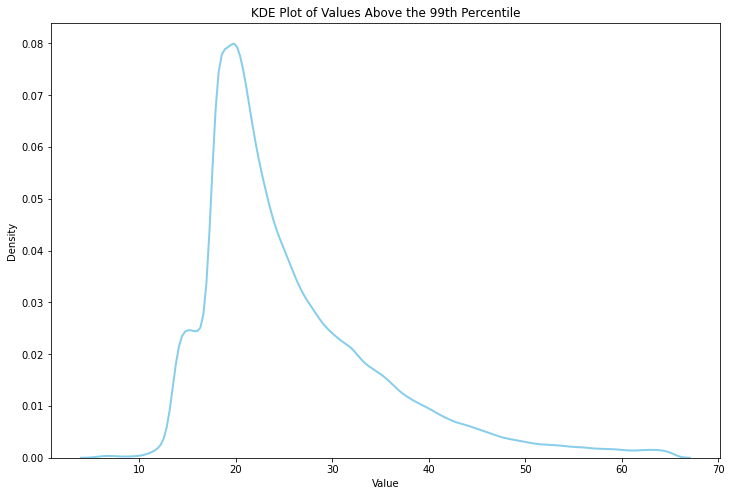

In [8]:
if how == 'paris':
    plot_interacting_region_kde_paris(df, savepath = os.path.join(plots_dir, f'interacting_region_hist_{how}.pdf'))

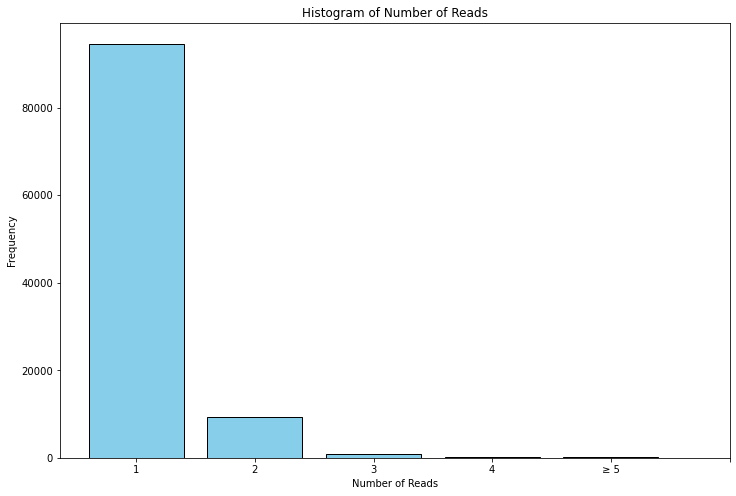

In [9]:
if how == 'ricseq':
    upper = 10
    plot_bar_n_reads_hist(df, upper = upper, savepath = os.path.join(plots_dir, f'n_reads_hist_{how}.pdf'))
elif how == 'paris':
    upper = 5
    plot_bar_n_reads_hist(df, upper = upper, savepath = os.path.join(plots_dir, f'n_reads_hist_{how}.pdf'))

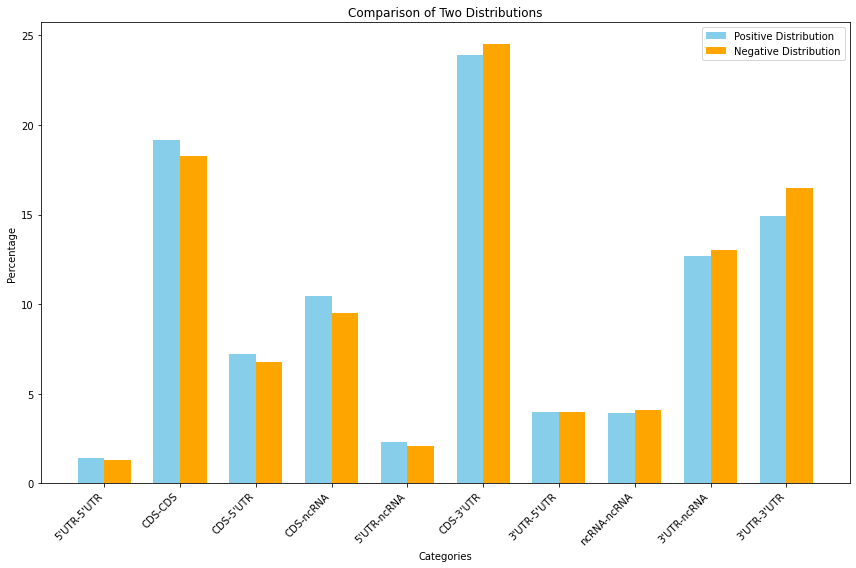

In [8]:
plot_interaction_region(df, savepath = os.path.join(plots_dir, f'interactions_composition_{how}.pdf'))

/data01/giorgio/RNARNA-NT/src/../util/plot_utils.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['where'] = df['where'].apply(lambda x: x.replace("UTR5", "5'UTR"))
/data01/giorgio/RNARNA-NT/src/../util/plot_utils.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['where'] = df['where'].apply(lambda x: x.replace("UTR3", "3'UTR"))
/data01/giorgio/RNARNA-NT/src/../util/plot_utils.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

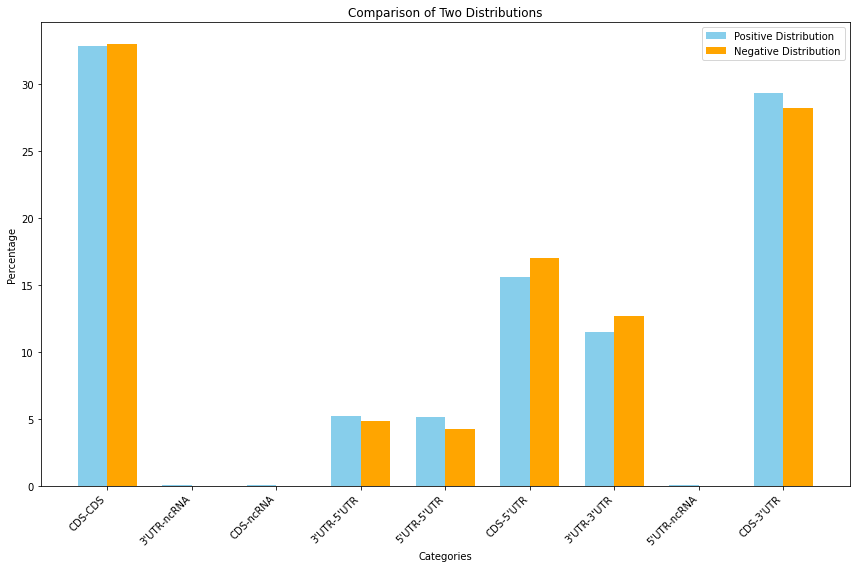

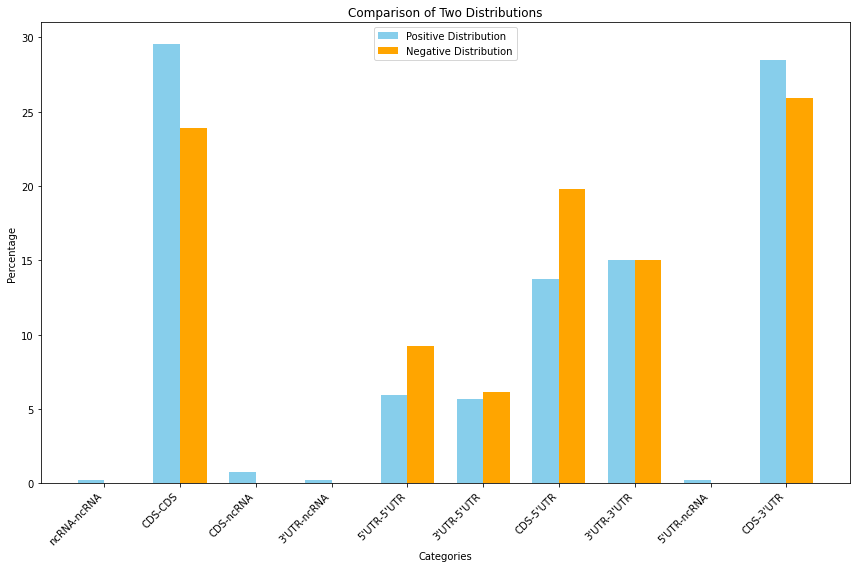

In [27]:
if how == 'paris':
    gene_pairs_train, gene_pairs_test, gene_pairs_val = load_train_test_val_lists(rna_rna_files_dir, how = how)
    
    train, test, val = df[df.couples.isin(gene_pairs_train)], df[df.couples.isin(gene_pairs_test)], df[df.couples.isin(gene_pairs_val)]

    plot_interaction_region(train, savepath = os.path.join(plots_dir, f'interactions_composition_paris_train.pdf'))
    plot_interaction_region(test, savepath = os.path.join(plots_dir, f'interactions_composition_paris_test.pdf'))
    plot_interaction_region(val, savepath = os.path.join(plots_dir, f'interactions_composition_paris_val.pdf'))
    
    gene_pairs_train_hq, gene_pairs_test_hq, gene_pairs_val_hq = load_train_test_val_lists(rna_rna_files_dir, how = how, hq = True)
    train_hq, test_hq, val_hq = df[df.couples.isin(gene_pairs_train_hq)], df[df.couples.isin(gene_pairs_test_hq)], df[df.couples.isin(gene_pairs_val_hq)]

    # plot_interaction_region(train_hq)
    # plot_interaction_region(test_hq)
    # plot_interaction_region(val_hq)
    
    assert set(train_hq[train_hq.interacting].couples) - set(train[train.interacting].couples) == set()
    
else: 
    gene_pairs_train, gene_pairs_test = load_train_test_val_lists(rna_rna_files_dir, how = how)

    train, test = df[df.couples.isin(gene_pairs_train)], df[df.couples.isin(gene_pairs_test)]

    plot_interaction_region(train)
    plot_interaction_region(test)

In [19]:
train_test = set(train.couples).intersection(test.couples)

if len(train_test)>0:
    assert (train[train.couples.isin(train_test)].interacting == False).all()
    
if how == 'paris':
    train_val = set(train.couples).intersection(val.couples)
    if len(train_val)>0:
        assert (train[train.couples.isin(train_val)].interacting == False).all()

### Interaction Length distribution

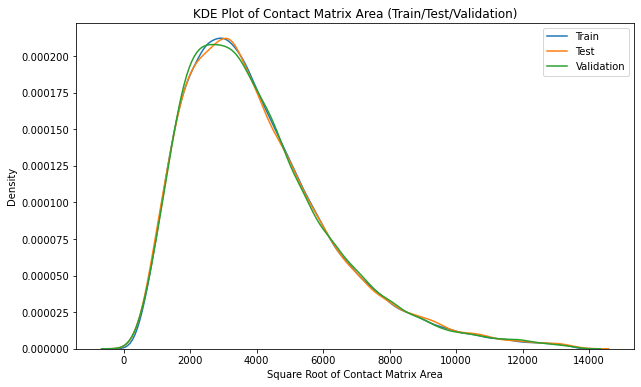

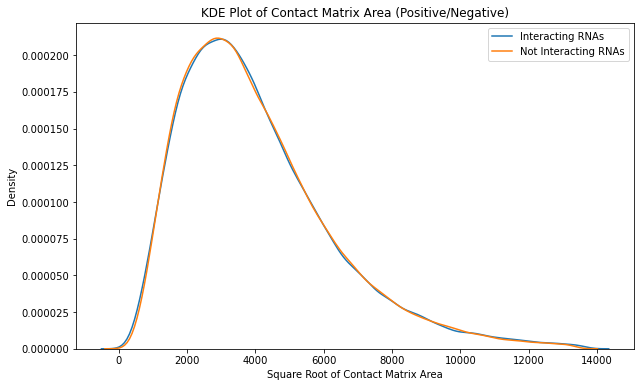

In [20]:
if how =='paris':
    plot_matrix_area_kde_curves(
        datasets=[train, test, val],
        labels=["Train", "Test", "Validation"],
        title="KDE Plot of Contact Matrix Area (Train/Test/Validation)",
        savepath=os.path.join(plots_dir, 'contact_matrix_area_kde_traintestval.pdf')
    )

    plot_matrix_area_kde_curves(
        datasets=[df[df.interacting==True], df[df.interacting==False]],
        labels=["Interacting RNAs", "Not Interacting RNAs"],
        title="KDE Plot of Contact Matrix Area (Positive/Negative)",
        savepath=os.path.join(plots_dir, 'contact_matrix_area_kde_posneg.pdf')
    )

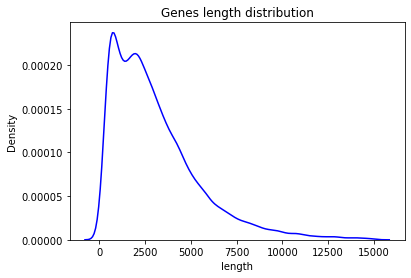

2518.0
3062.1727733611806
205012


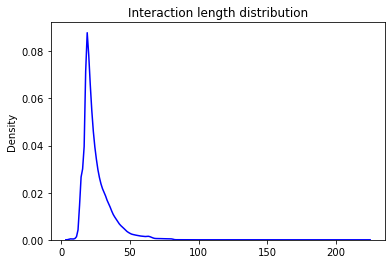

In [27]:
sns.kdeplot(df_genes[df_genes.length<15_000].length, color = 'blue')
plt.title(f'Genes length distribution')
plt.show()
print(df_genes.length.median())
print(df_genes.length.std())
print(df_genes.length.max())

df_int = df[df.interacting]
lengths = list(pd.concat([df_int.w, df_int.h]))
sns.kdeplot(lengths, color = 'blue')
plt.title(f'Interaction length distribution')
plt.show()

### Now I do checks

In [26]:
df_int, df_neg = df[df.interacting],  df[df.interacting == False]

df_int1 = df_int[['gene1', 'x1', 'w']].rename({'gene1':'gene', 'x1':'c1',  'w': 'l'}, axis = 1)
df_int2 = df_int[['gene2', 'y1', 'h']].rename({'gene2':'gene', 'y1':'c1',  'h': 'l'}, axis = 1)
df_coord = pd.concat([df_int1, df_int2], ignore_index = True)#.drop_duplicates().reset_index(drop = True)


#check if it worked
assert (df_neg.x1 <= df_neg.length_1).all()
assert ((df_neg.x1 + df_neg.w) <= df_neg.length_1).all()
assert (df_neg.y1 <= df_neg.length_2).all()
assert ((df_neg.y1 + df_neg.h) <= df_neg.length_2).all()

# 37 min
#check if it worked
start_time = time.time()
for _, row in df_neg.iterrows():
    g1 = row.gene1
    g2 = row.gene2
    assert [row.x1, row.w] in df_coord[df_coord.gene == g1][['c1', 'l']].values
    assert [row.y1, row.h] in df_coord[df_coord.gene == g2][['c1', 'l']].values
    if np.random.rand() < 0.0003: #progress
        print(f"{np.round(_/df_neg.shape[0] * 100, 2)}% in {(time.time()-start_time)/60} minutes")
print(f"Total time: {(time.time()-start_time)/60} minutes")

139.05% in 0.042946922779083255 minutes
Total time: 0.054123055934906 minutes


### Degree

In [29]:
def obtain_gene_count_real(df):
    vc = df.interacting.value_counts()
    if set(vc.index) == {False, True}:
        unbalance_factor = vc[True]/vc[False]
    else:
        unbalance_factor = np.nan
    gene_count_pos_list = list(df[df.interacting].gene1) + list(df[df.interacting].gene2)
    gene_count_neg_list = list(df[df.interacting == False].gene1) + list(df[df.interacting == False].gene2)

    gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
    gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
    gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
    
    gene_count_res['weight'] = 1
    gene_count_res.loc[ gene_count_res.interacting == 0, 'weight'] = unbalance_factor
    gene_count_real = gene_count_res.groupby('gene').sum()
    gene_count_real['not_interacting'] = gene_count_real['weight'] - gene_count_real['interacting']
    gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
    gene_count_real['total'] = gene_count_real['not_interacting'] + gene_count_real['interacting']
    gene_count_real = gene_count_real.reset_index()#add gene column
    return gene_count_real

In [30]:
gene_count = obtain_gene_count_real(train)

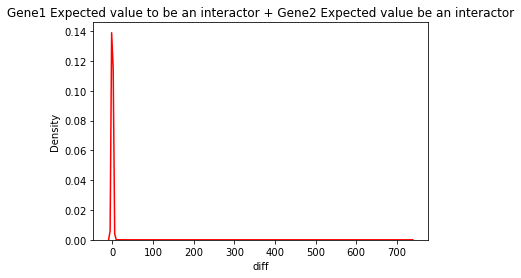

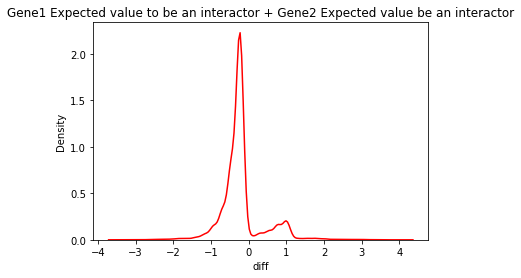

percentage of genes within the tolerance treshold 0.999 %
percentage of data within the tolerance treshold 0.725 %


In [31]:
tolerance = 10

sns.kdeplot(gene_count['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

sns.kdeplot(gene_count[gene_count['diff']<tolerance]['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()


subset = gene_count[(gene_count['diff']<tolerance)&(gene_count['diff']>-tolerance)]
subset_treshold = df[(df.gene1.isin(subset.gene)&df.gene2.isin(subset.gene))]

print(f'percentage of genes within the tolerance treshold {(subset.shape[0] / gene_count.shape[0]):.3f} %')
print(f'percentage of data within the tolerance treshold {(subset_treshold.shape[0] / df.shape[0]):.3f} %')

# Stats of train-test-val

In [ ]:
import dataset.train_test_val_utils as utils

how = 'paris'

In [ ]:
all_couples = set(gene_pairs_train).union(set(gene_pairs_val)).union(set(gene_pairs_test)) 

print('tot:',len(all_couples))

print('- - - split - - -')

print('train:', len(set(gene_pairs_train)))

print('test:', len(set(gene_pairs_test)))

print('val:', len(set(gene_pairs_val)))

df_train_genes = set(train['gene1']).union(set(train['gene2']))
couples_train = set(train['couples'])

df_test_genes = set(test['gene1']).union(set(test['gene2']))
couples_test = set(test['couples'])

df_val_genes = set(val['gene1']).union(set(val['gene2']))
couples_val = set(val['couples'])

In [ ]:
print('# of couples between train and val', len(couples_val.intersection(couples_train)) )
print('# of couples between train and test', len(couples_train.intersection(couples_test)) )
print('# of couples between val and test', len(couples_val.intersection(couples_test)) )

In [ ]:
couples_test_val = couples_test.union(couples_val)
all_couples = couples_test_val.union(couples_train)

print('# of total couples: ', len(all_couples))
train_perc = np.round(len(couples_train)/len(all_couples)*100,2)
test_perc = np.round(len(couples_test)/len(all_couples)*100,2)
val_perc = np.round(len(couples_val)/len(all_couples)*100,2)
print(f'La percentuale di coppie nel training è {train_perc}')
print(f'La percentuale di coppie nel test è {test_perc}')
print(f'La percentuale di coppie nel validation è {val_perc}')

test_not_in_train = test[~(test.gene1.isin(df_train_genes) | test.gene2.isin(df_train_genes))]
test_not_in_train = set(test_not_in_train.couples)
val_not_in_train = val[~(val.gene1.isin(df_train_genes) | val.gene2.isin(df_train_genes))]
val_not_in_train = set(val_not_in_train.couples)

perc_test_notrain = np.round(len(test_not_in_train)/len(couples_test)*100, 2)
perc_val_notrain = np.round(len(val_not_in_train)/len(couples_val)*100, 2)

print(f'La percentuale di coppie nel test non nel training (rispetto al totale del test set) è {perc_test_notrain}')
print(f'La percentuale di coppie nel validation non nel training (rispetto al totale del validation set) è {perc_val_notrain}')
print(f'Il numero di coppie nel test non nel training è {len(test_not_in_train)}')
print(f'Il numero di coppie nel test (positive) non nel training è  {len(set(df[df.couples.isin(test_not_in_train)&df.interacting].couples))}')
print(f'Il numero di coppie nel val non nel training è {len(val_not_in_train)}')
print(f'Il numero di coppie nel val (positive) non nel training è  {len(set(df[df.couples.isin(val_not_in_train)&df.interacting].couples))}')

In [ ]:
# df_labels = df[['couples', 'interacting']].drop_duplicates().reset_index(drop = True)
# assert df_labels.shape[0] == len(df['couples'].unique())
# df_labels['interacting'] = df_labels['interacting'].astype('int')


# train, test_val = train_test_split(df_labels, test_size=0.3, random_state=0, stratify=df_labels[['interacting']])
# test, val = train_test_split(test_val, test_size=0.5, random_state=0, stratify=test_val[['interacting']])

# gene_pairs_training = list(set(train.couples))
# gene_pairs_test = list(set(val.couples))
# gene_pairs_val = list(set(test.couples))
# utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)

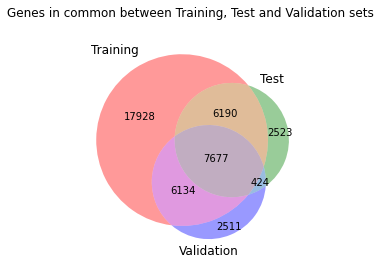

In [55]:
utils.venn_between_genes(gene_pairs_train, gene_pairs_test, gene_pairs_val)

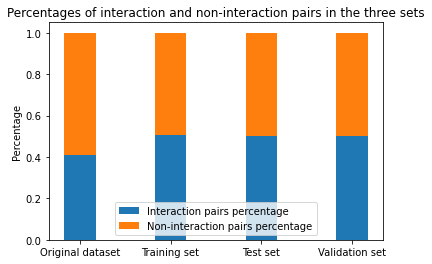

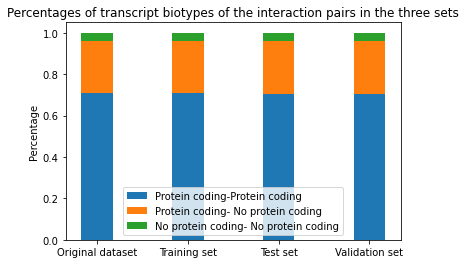

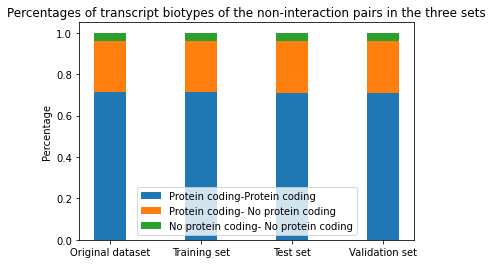

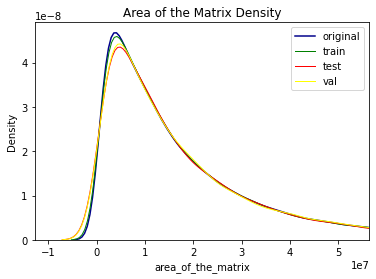

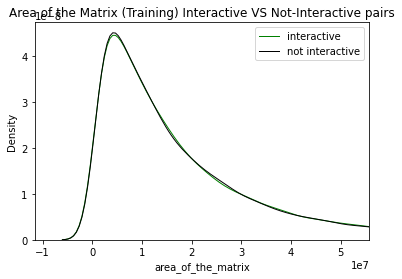

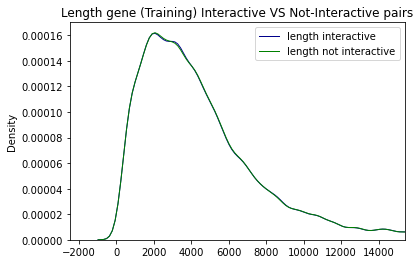

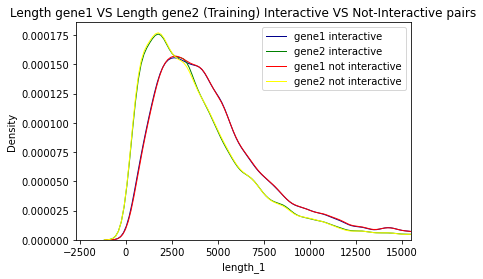

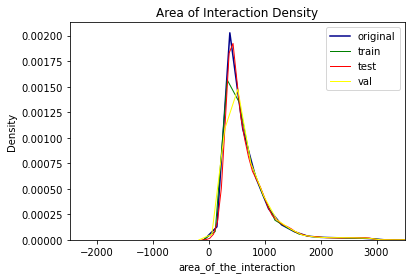

In [56]:
utils.plot_stats(df, gene_pairs_train, gene_pairs_test, gene_pairs_val, limit_plot = 100_000_000)

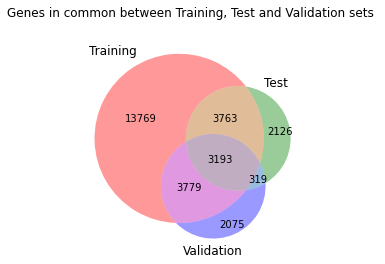

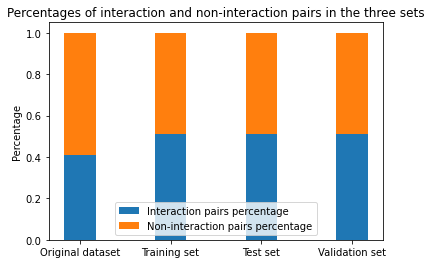

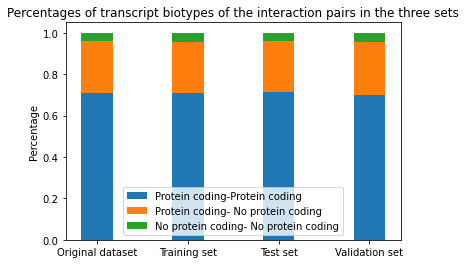

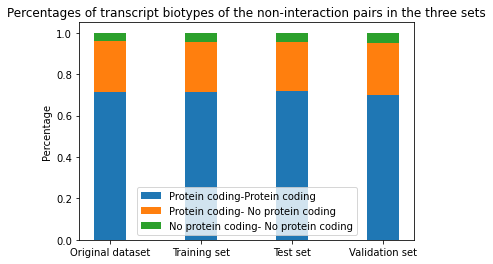

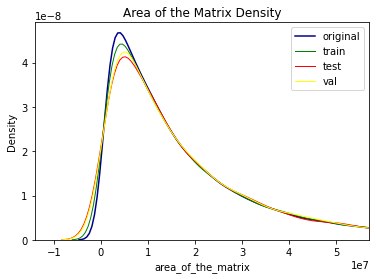

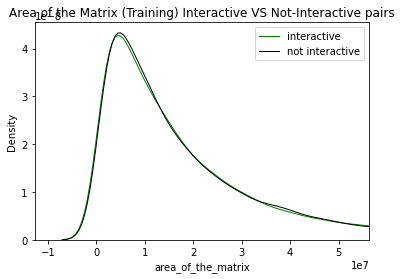

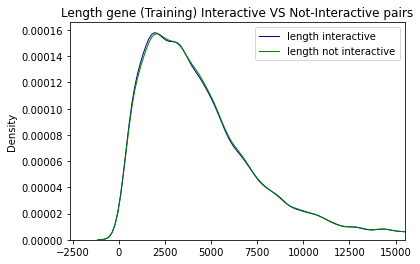

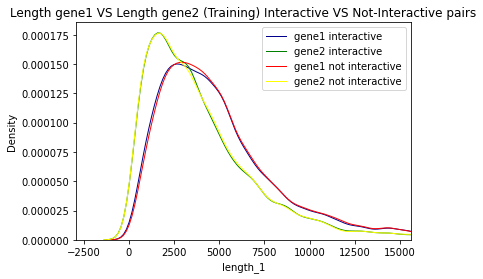

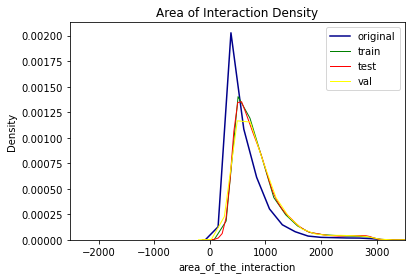

In [59]:
utils.venn_between_genes(gene_pairs_train_hq, gene_pairs_test_hq, gene_pairs_val_hq)

utils.plot_stats(df, gene_pairs_train_hq, gene_pairs_test_hq, gene_pairs_val_hq, limit_plot = 100_000_000)